c:\Users\name\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.2+cu121)
    Python  3.8.10 (you have 3.8.5)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
100%|██████████| 50/50 [00:02<00:00, 17.22it/s]


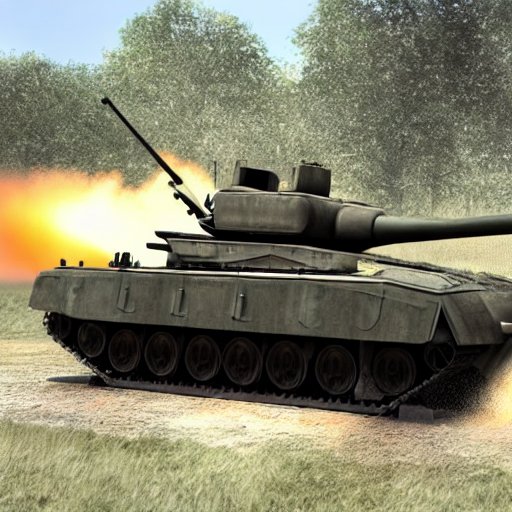

In [1]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipeline.to("cuda")
pipeline("a main battle tank in action, photorealistic").images[0]

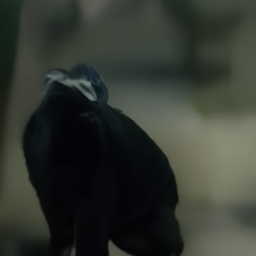

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel
from PIL import Image
import torch

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")
scheduler.set_timesteps(50)

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
        prev_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
        input = prev_noisy_sample

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

In [ ]:
import pandas as pd
import os
import requests
from tqdm import tqdm
import time
import random
from PIL import Image
from io import BytesIO
import urllib.parse
import re
from bs4 import BeautifulSoup

# Function to extract the actual image URL from a Wikimedia Commons page
def get_actual_image_url(commons_url):
    try:
        # Request the Wikimedia Commons page
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(commons_url, headers=headers, timeout=10)
        
        if response.status_code != 200:
            return None
        
        # Parse the HTML
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Method 1: Find the fullImageLink
        full_img_div = soup.find('div', {'class': 'fullImageLink'})
        if full_img_div and full_img_div.find('a'):
            img_url = full_img_div.find('a').get('href')
            if img_url.startswith('//'):
                img_url = 'https:' + img_url
            return img_url
        
        # Method 2: Find the file history table
        file_history = soup.find('table', {'class': 'filehistory'})
        if file_history:
            rows = file_history.find_all('tr')
            if len(rows) > 1:  # Skip header row
                cells = rows[1].find_all('td')
                if len(cells) >= 2:
                    link = cells[1].find('a')
                    if link:
                        img_url = link.get('href')
                        if img_url.startswith('//'):
                            img_url = 'https:' + img_url
                        return img_url
        
        # Method 3: Look for the mw-mmv-download-go button's href
        download_link = soup.find('a', {'class': 'mw-mmv-download-go'})
        if download_link:
            img_url = download_link.get('href')
            if img_url.startswith('//'):
                img_url = 'https:' + img_url
            return img_url
            
        # Method 4: Find any image with the same filename
        filename = commons_url.split('File:')[-1].split('#')[0]
        filename = urllib.parse.unquote(filename)
        imgs = soup.find_all('img')
        for img in imgs:
            src = img.get('src', '')
            if filename.replace(' ', '_') in src:
                img_url = img.get('src')
                if img_url.startswith('//'):
                    img_url = 'https:' + img_url
                return img_url
        
        return None
    except Exception as e:
        print(f"Error parsing Wikimedia page {commons_url}: {str(e)}")
        return None

# Function to download an image from a URL
def download_image(url, save_dir, file_name=None):
    try:
        # Check if this is a Wikimedia Commons URL
        if 'commons.wikimedia.org/wiki/File' in url:
            # Get the actual image URL
            actual_url = get_actual_image_url(url)
            if actual_url:
                url = actual_url
            else:
                print(f"Could not extract actual image URL from {url}")
                return None
        
        # Add headers to mimic a browser request
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # Send request with a timeout
        response = requests.get(url, headers=headers, timeout=10)
        
        # Check if the request was successful
        if response.status_code == 200:
            # If no filename provided, create one from the URL or use a timestamp
            if file_name is None:
                # Try to extract filename from URL
                parsed_url = urllib.parse.urlparse(url)
                url_filename = os.path.basename(parsed_url.path)
                
                # If URL doesn't have a clear filename, use timestamp
                if not url_filename or '.' not in url_filename:
                    timestamp = int(time.time() * 1000)
                    file_name = f"image_{timestamp}.jpg"
                else:
                    file_name = url_filename
            
            # Clean up filename - remove URL encoding and invalid characters
            file_name = urllib.parse.unquote(file_name)
            file_name = re.sub(r'[\\/*?:"<>|]', '_', file_name)  # Replace invalid chars
            
            # Ensure the filename has an extension
            if not any(file_name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.webp', '.gif']):
                file_name += '.jpg'
            
            # Make sure filename isn't too long (Windows has a 260 char path limit)
            if len(file_name) > 100:  # Arbitrary length to avoid path issues
                extension = os.path.splitext(file_name)[1]
                file_name = file_name[:95] + extension
            
            # Create full path
            save_path = os.path.join(save_dir, file_name)
            
            # Open the image and convert to RGB (removes transparency if any)
            try:
                img = Image.open(BytesIO(response.content)).convert('RGB')
                
                # Save the image
                img.save(save_path)
                return save_path
            except Exception as e:
                print(f"Error processing image from {url}: {str(e)}")
                return None
        else:
            print(f"Failed to download {url}, status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error downloading {url}: {str(e)}")
        return None

# Main function to process the dataset
def localize_dataset_images(csv_path, output_dir, output_csv_path=None):
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    
    # Read the CSV file
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset with {len(df)} entries")
    
    # Create a copy of the dataframe for the processed data
    processed_df = df.copy()
    
    # Download images and update the URL in the new dataframe
    successful_downloads = 0
    failed_downloads = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Downloading images"):
        # Check if URL exists and is not empty
        if pd.notna(row['URL']) and row['URL'].strip():
            # Use file name from CSV if available, otherwise None will use URL-based name
            file_name = row['File Name'] if pd.notna(row['File Name']) and row['File Name'].strip() else None
            
            # Download the image
            local_path = download_image(row['URL'], output_dir, file_name)
            
            if local_path:
                # Replace the URL with the local file path in the processed dataframe
                # Use an absolute path for better compatibility with training scripts
                abs_path = os.path.abspath(local_path)
                processed_df.at[idx, 'URL'] = abs_path
                successful_downloads += 1
            else:
                failed_downloads += 1
                # Leave the URL unchanged if download failed
                
            # Add a small delay to avoid overwhelming the server
            time.sleep(random.uniform(0.5, 1.0))
    
    # Save the processed dataframe
    if output_csv_path is None:
        base_name = os.path.splitext(os.path.basename(csv_path))[0]
        output_csv_path = os.path.join(output_dir, f"{base_name}_localized.csv")
    
    processed_df.to_csv(output_csv_path, index=False)
    
    # Print summary
    print(f"\nDownload Summary:")
    print(f"Total successful downloads: {successful_downloads}/{len(df)}")
    print(f"Failed downloads: {failed_downloads}")
    print(f"Processed CSV saved to: {output_csv_path}")
    
    return processed_df, output_csv_path

# Example usage
if __name__ == "__main__":
    # Define paths
    csv_path = "C:\\Users\\name\\Downloads\\image_data.csv"  # Path to your original CSV
    output_dir = "C:\\Users\\name\\Downloads\\Tank_Images"  # Directory to save downloaded images
    output_csv_path = "C:\\Users\\name\\Downloads\\image_data_localized.csv"  # Path for the new CSV
    
    # Process the CSV and download images
    processed_df, saved_csv_path = localize_dataset_images(csv_path, output_dir, output_csv_path)
    
    print("\nProcessing complete!")
    print(f"1. Downloaded images are in: {output_dir}")
    print(f"2. Processed CSV with local file paths: {saved_csv_path}")
    print(f"3. You can now use this CSV directly for AI model training.")

Loaded dataset with 1042 entries


Error processing image from https://upload.wikimedia.org/wikipedia/commons/8/8d/Czo%C5%82g_-_panoramio.jpg: broken data stream when reading image file


Error processing image from https://upload.wikimedia.org/wikipedia/commons/8/86/MBT_silhouettes.svg: cannot identify image file <_io.BytesIO object at 0x0000027ACC4444A0>


Error processing image from https://upload.wikimedia.org/wikipedia/commons/c/c4/PT91_tank.svg: cannot identify image file <_io.BytesIO object at 0x0000027A25DA8130>


Could not extract actual image URL from https://commons.wikimedia.org/wiki/File%3AUA_T-72B1_with_slat_armor_01.jpg


Could not extract actual image URL from https://commons.wikimedia.org/wiki/File%3AUA_T-72B1_with_slat_armor_02.jpg


Could not extract actual image URL from https://commons.wikimedia.org/wiki/File%3AUA_T-72B1_with_slat_armor_03.jpg


Error downloading https://upload.wikimedia.org/wikipedia/commons/2/24/Army2016demo-039.jpg: HTTPSConnectionPool(host='upload.wikimedia.org', port=443): Read timed out. (read timeout=10)



Download Summary:
Total successful downloads: 1035/1042
Failed downloads: 7
Processed CSV saved to: C:\Users\name\Downloads\image_data_localized.csv

Processing complete!
1. Downloaded images are in: C:\Users\name\Downloads\Tank_Images
2. Processed CSV with local file paths: C:\Users\name\Downloads\image_data_localized.csv
3. You can now use this CSV directly for AI model training.


In [ ]:
import os
import torch
import numpy as np
import math
from PIL import Image
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from diffusers.optimization import get_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from tqdm.auto import tqdm

# Import PEFT modules
from peft import LoraConfig, get_peft_model

# Define a simple training config
class TrainingConfig:
    # Model settings
    pretrained_model_name = "runwayml/stable-diffusion-v1-5"
    output_dir = "tank_diffusion_model"
    seed = 42
    
    # Training settings
    train_batch_size = 1
    num_train_epochs = 30
    max_train_steps = None
    gradient_accumulation_steps = 4
    learning_rate = 1e-4
    lr_scheduler = "constant"
    lr_warmup_steps = 0
    
    # LoRA specific settings
    lora_rank = 16
    lora_alpha = 32
    lora_dropout = 0.05
    
    # Data settings - FIXED PATH
    train_data_dir = "C:\\Users\\name\\Downloads\\Tank_Data"  # <- IMPORTANT: This is a simple directory name
    resolution = 512
    center_crop = True
    random_flip = True
    
    # Other settings
    mixed_precision = "fp16"  # Use mixed precision training to save memory
    enable_xformers_memory_efficient_attention = False  # DISABLED xformers

# Dataset for tank images
class TankDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        size=512,
        center_crop=True,
        random_flip=True,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.size = size
        self.center_crop = center_crop
        self.random_flip = random_flip
        
        # Check if the data_root exists and is a directory
        if not os.path.exists(data_root):
            raise ValueError(f"Data directory {data_root} does not exist.")
        
        if not os.path.isdir(data_root):
            raise ValueError(f"{data_root} is not a directory.")
        
        # Get all image files
        self.image_paths = [os.path.join(data_root, f) for f in os.listdir(data_root) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]
        
        self.num_images = len(self.image_paths)
        self._length = self.num_images
        
        if self.num_images == 0:
            print(f"WARNING: No images found in {data_root}")
        else:
            print(f"Found {self.num_images} images in {data_root}")
        
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.RandomHorizontalFlip() if random_flip else transforms.Lambda(lambda x: x),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        
        # Tank-specific prompts
        self.tank_prompts = [
            "a highly detailed photo of a military tank",
            "a photorealistic image of a battle tank",
            "a professional photograph of a modern tank",
            "a realistic military tank in combat",
            "a detailed render of an armored tank vehicle",
            "a high-resolution image of a tank in a desert",
            "a military tank in an urban environment, photorealistic",
            "a modern main battle tank, highly detailed",
            "an armored tank vehicle with realistic details",
            "a tank with realistic camouflage and weathering"
        ]

    def __len__(self):
        return self._length
    
    def __getitem__(self, index):
        example = {}
        
        # Get image
        image_path = self.image_paths[index % self.num_images]
        try:
            image = Image.open(image_path)
            if not image.mode == "RGB":
                image = image.convert("RGB")
            example["pixel_values"] = self.image_transforms(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Use a fallback image or skip
            return self.__getitem__((index + 1) % self._length)
        
        # Get text prompt - randomly select from our list of prompts
        text = np.random.choice(self.tank_prompts)
        
        # Tokenize text
        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]
        
        return example

# Training function using PEFT for LoRA fine-tuning
def train():
    config = TrainingConfig()
    
    # Initialize accelerator
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision,
    )
    
    # Report accelerator state
    print(accelerator.state, flush=True)
    
    # Create output directory
    os.makedirs(config.output_dir, exist_ok=True)
    
    # Load the tokenizer
    tokenizer = CLIPTokenizer.from_pretrained(
        config.pretrained_model_name,
        subfolder="tokenizer",
    )
    
    # Load models
    text_encoder = CLIPTextModel.from_pretrained(
        config.pretrained_model_name, 
        subfolder="text_encoder"
    )
    
    # Load VAE for proper conversion to latent space
    vae = AutoencoderKL.from_pretrained(
        config.pretrained_model_name,
        subfolder="vae",
    )
    
    # Load UNet
    unet = UNet2DConditionModel.from_pretrained(
        config.pretrained_model_name, 
        subfolder="unet"
    )
    
    # Freeze all models except for the UNet with LoRA
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    unet.requires_grad_(False)
    
    # Configure LoRA for UNet using PEFT
    target_modules = [
        "to_q", 
        "to_k", 
        "to_v", 
        "to_out.0"
    ]
    
    # Create LoRA config using PEFT
    unet_lora_config = LoraConfig(
        r=config.lora_rank,
        lora_alpha=config.lora_alpha,
        target_modules=target_modules,
        lora_dropout=config.lora_dropout,
        bias="none",
    )
    
    # Prepare the UNet with LoRA using PEFT
    print("Setting up UNet with PEFT LoRA adapters...")
    unet = get_peft_model(unet, unet_lora_config)
    
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in unet.parameters())
    print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")
    
    # Create optimizer
    optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=config.learning_rate,
    )
    
    # Get the training dataset
    train_dataset = TankDataset(
        data_root=config.train_data_dir,
        tokenizer=tokenizer,
        size=config.resolution,
        center_crop=config.center_crop,
        random_flip=config.random_flip,
    )
    
    # Print dataset info
    print(f"Number of training images: {len(train_dataset)}")
    if len(train_dataset) == 0:
        raise ValueError(f"No training images found in {config.train_data_dir}. Please check the path.")
    
    # Create dataloader
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config.train_batch_size, 
        shuffle=True
    )
    
    # Scheduler and training steps calculation
    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config.gradient_accumulation_steps)
    
    if config.max_train_steps is None:
        config.max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True
    
    # Create learning rate scheduler
    lr_scheduler = get_scheduler(
        config.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps * accelerator.num_processes,
        num_training_steps=config.max_train_steps * accelerator.num_processes,
    )
    
    # Prepare everything with accelerator
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )
    
    # Move models to device
    vae = vae.to(accelerator.device).eval()
    text_encoder = text_encoder.to(accelerator.device).eval()
    
    # Recalculate training info
    if overrode_max_train_steps:
        config.max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
    config.num_train_epochs = math.ceil(config.max_train_steps / num_update_steps_per_epoch)
    
    # Train!
    total_batch_size = config.train_batch_size * accelerator.num_processes * config.gradient_accumulation_steps
    
    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(f"  Num Epochs = {config.num_train_epochs}")
    print(f"  Batch size per device = {config.train_batch_size}")
    print(f"  Total train batch size = {total_batch_size}")
    print(f"  Gradient Accumulation steps = {config.gradient_accumulation_steps}")
    print(f"  Total optimization steps = {config.max_train_steps}")
    
    # Progress bar
    progress_bar = tqdm(range(config.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0
    
    # Get the noise scheduler for training
    noise_scheduler = DDPMScheduler.from_pretrained(config.pretrained_model_name, subfolder="scheduler")
    
    # Training loop
    for epoch in range(config.num_train_epochs):
        unet.train()
        
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Get text embeddings
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]
                
                # Convert images to latent space using VAE
                with torch.no_grad():
                    # Scale down pixel values to [-1, 1] (should already be done by transforms)
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor
                
                # Add noise to the latents (forward diffusion process)
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()
                
                # Add noise to the latents according to the noise magnitude at each timestep
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                
                # Predict the noise residual
                model_output = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
                
                # Calculate loss
                loss = F.mse_loss(model_output, noise, reduction="mean")
                
                # Backpropagate
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                
                # Update parameters
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            # Update progress
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                
                # Save checkpoint
                if global_step % 500 == 0 and accelerator.is_main_process:
                    save_path = os.path.join(config.output_dir, f"checkpoint-{global_step}")
                    os.makedirs(save_path, exist_ok=True)
                    
                    # Save the LoRA weights
                    unwrapped_unet = accelerator.unwrap_model(unet)
                    unwrapped_unet.save_pretrained(save_path)
                    print(f"Saved checkpoint at step {global_step}")
            
            # Log progress
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            
            if global_step >= config.max_train_steps:
                break
        
    # Save the final model
    if accelerator.is_main_process:
        print("Saving final model...")
        unwrapped_unet = accelerator.unwrap_model(unet)
        unwrapped_unet.save_pretrained(config.output_dir)
        print(f"Model saved to {config.output_dir}")

# Function to load the trained model and generate images
def generate_tank_images(
    prompt="a highly detailed photorealistic military tank in a desert environment",
    num_images=4,
    num_inference_steps=50,
    guidance_scale=7.5,
    negative_prompt="low quality, blurry, distorted, unrealistic"
):
    config = TrainingConfig()
    
    print(f"Loading models to generate tank images...")
    
    # Load base pipeline
    pipeline = StableDiffusionPipeline.from_pretrained(
        config.pretrained_model_name,
        torch_dtype=torch.float16,
    )
    
    # Load LoRA UNet
    from peft import PeftModel
    
    # Check if the model exists
    if not os.path.exists(os.path.join(config.output_dir, "adapter_config.json")):
        print(f"No trained model found in {config.output_dir}. Please run train() first.")
        return []
    
    print("Loading LoRA weights...")
    pipeline.unet = PeftModel.from_pretrained(
        pipeline.unet,
        config.output_dir,
        adapter_name="default"
    )
    
    pipeline.to("cuda")
    
    # Generate images
    images = []
    print(f"Generating tank images with prompt: '{prompt}'")
    with torch.autocast("cuda"):
        for i in range(num_images):
            image = pipeline(
                prompt=prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            ).images[0]
            
            images.append(image)
            
            # Save image
            os.makedirs("generated_tanks", exist_ok=True)
            save_path = f"generated_tanks/tank_{i}.png"
            image.save(save_path)
            print(f"Saved image to {save_path}")
    
    return images

# Main execution
if __name__ == "__main__":
    print("Starting the tank image generation model training...")
    
    # Check if PEFT is installed
    try:
        import peft
        print("PEFT library is installed and ready to use.")
    except ImportError:
        print("PEFT library is not installed. Installing now...")
        import subprocess
        subprocess.check_call(["pip", "install", "peft"])
        print("PEFT installed successfully.")
    
    # Create a directory for tank images if it doesn't exist
    config = TrainingConfig()
    
    # IMPORTANT: Make sure this is a directory, not a file
    print(f"Creating directory for tank images: {config.train_data_dir}")
    os.makedirs(config.train_data_dir, exist_ok=True)
    
    # Check if there are any images in the directory
    image_files = [f for f in os.listdir(config.train_data_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]
    num_images = len(image_files)
    
    if num_images == 0:
        print(f"WARNING: No images found in {config.train_data_dir}")
        print("Please add some tank images to this directory before training.")
        print("Instructions:")
        print("1. Copy your tank images to the 'tank_images' folder")
        print("2. Run this script again")
        exit(1)
    else:
        print(f"Found {num_images} images for training:")
        for i, img in enumerate(image_files[:5]):
            print(f"  - {img}")
        if num_images > 5:
            print(f"  - ... and {num_images - 5} more")
        
        # Train the model
        print("\nStarting model training...")
        train()
        
        # Generate sample images
        print("\nGenerating sample tank images...")
        generate_tank_images()
        
        # Try different prompts
        prompts = [
            "a photorealistic military tank in a snowy environment, detailed",
            "a realistic tank in an urban combat zone, high resolution",
            "a main battle tank in action, photorealistic"
        ]
        
        for i, prompt in enumerate(prompts):
            print(f"\nGenerating tank image with prompt: '{prompt}'")
            generate_tank_images(prompt=prompt, num_images=1)

c:\Users\name\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.2+cu121)
    Python  3.8.10 (you have 3.8.5)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Starting the tank image generation model training...
PEFT library is installed and ready to use.
Creating directory for tank images: C:\Users\name\Downloads\Tank_Data
Found 1079 images for training:
  - altay_l1.jpg
  - altay_l2.jpg
  - altay_l3.jpg
  - altay_l4.jpg
  - altay_l5.jpg
  - ... and 1074 more

Starting model training...
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

Setting up UNet with PEFT LoRA adapters...
Trainable parameters: 3,188,736 / 862,709,700 (0.37%)
Found 1079 images in C:\Users\name\Downloads\Tank_Data
Number of training images: 1079
***** Running training *****
  Num examples = 1079
  Num Epochs = 30
  Batch size per device = 1
  Total train batch size = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 8100


Steps:   6%|▌         | 500/8100 [08:20<2:06:55,  1.00s/it, loss=0.0643, lr=0.0001] 

Saved checkpoint at step 500


Steps:  12%|█▏        | 1000/8100 [16:33<1:57:32,  1.01it/s, loss=0.0919, lr=0.0001]

Saved checkpoint at step 1000


Steps:  19%|█▊        | 1500/8100 [24:51<1:47:47,  1.02it/s, loss=0.277, lr=0.0001]  

Saved checkpoint at step 1500


Steps:  25%|██▍       | 2000/8100 [33:05<1:41:12,  1.00it/s, loss=0.186, lr=0.0001]  

Saved checkpoint at step 2000


Steps:  31%|███       | 2500/8100 [41:18<1:32:05,  1.01it/s, loss=0.616, lr=0.0001]  

Saved checkpoint at step 2500


Steps:  37%|███▋      | 3000/8100 [49:35<1:23:27,  1.02it/s, loss=0.00885, lr=0.0001]

Saved checkpoint at step 3000


Steps:  43%|████▎     | 3500/8100 [57:50<1:16:06,  1.01it/s, loss=0.303, lr=0.0001]  

Saved checkpoint at step 3500


Steps:  49%|████▉     | 4000/8100 [1:06:09<1:08:04,  1.00it/s, loss=0.34, lr=0.0001]   

Saved checkpoint at step 4000


Steps:  56%|█████▌    | 4500/8100 [1:14:23<59:24,  1.01it/s, loss=0.108, lr=0.0001]    

Saved checkpoint at step 4500


Steps:  62%|██████▏   | 5000/8100 [1:22:41<52:21,  1.01s/it, loss=0.341, lr=0.0001]    

Saved checkpoint at step 5000


Steps:  68%|██████▊   | 5500/8100 [1:30:59<42:42,  1.01it/s, loss=0.0252, lr=0.0001] 

Saved checkpoint at step 5500


Steps:  74%|███████▍  | 6000/8100 [1:39:25<35:35,  1.02s/it, loss=0.0505, lr=0.0001] 

Saved checkpoint at step 6000


Steps:  80%|████████  | 6500/8100 [1:47:36<25:57,  1.03it/s, loss=0.015, lr=0.0001]  

Saved checkpoint at step 6500


Steps:  86%|████████▋ | 7000/8100 [1:55:48<17:50,  1.03it/s, loss=0.00996, lr=0.0001]

Saved checkpoint at step 7000


Steps:  93%|█████████▎| 7500/8100 [2:03:57<09:53,  1.01it/s, loss=0.0621, lr=0.0001] 

Saved checkpoint at step 7500


Steps:  99%|█████████▉| 8000/8100 [2:12:06<01:38,  1.02it/s, loss=0.15, lr=0.0001]   

Saved checkpoint at step 8000


Steps: 100%|██████████| 8100/8100 [2:13:44<00:00,  1.01it/s, loss=0.0574, lr=0.0001] 


Saving final model...
Model saved to tank_diffusion_model

Generating sample tank images...
Loading models to generate tank images...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Loading LoRA weights...
Generating tank images with prompt: 'a highly detailed photorealistic military tank in a desert environment'


100%|██████████| 50/50 [00:03<00:00, 12.72it/s]


Saved image to generated_tanks/tank_0.png


100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


Saved image to generated_tanks/tank_1.png


100%|██████████| 50/50 [00:03<00:00, 13.28it/s]


Saved image to generated_tanks/tank_2.png


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


Saved image to generated_tanks/tank_3.png

Generating tank image with prompt: 'a photorealistic military tank in a snowy environment, detailed'
Loading models to generate tank images...


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Loading LoRA weights...
Generating tank images with prompt: 'a photorealistic military tank in a snowy environment, detailed'


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


Saved image to generated_tanks/tank_0.png

Generating tank image with prompt: 'a realistic tank in an urban combat zone, high resolution'
Loading models to generate tank images...


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


Loading LoRA weights...
Generating tank images with prompt: 'a realistic tank in an urban combat zone, high resolution'


100%|██████████| 50/50 [00:03<00:00, 13.12it/s]


Saved image to generated_tanks/tank_0.png

Generating tank image with prompt: 'a main battle tank in action, photorealistic'
Loading models to generate tank images...


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


Loading LoRA weights...
Generating tank images with prompt: 'a main battle tank in action, photorealistic'


100%|██████████| 50/50 [00:03<00:00, 12.77it/s]


Saved image to generated_tanks/tank_0.png
